# Imports

In [1]:
import os
import time
import pickle
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
	Registered colormaps "rainbow" and "rainbow_r"...
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Prepare PCE Model

## Build Probe

In [2]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
taper_angle=17
Rtop=0
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=19e3/a_nm
freq_THz=a_nm/WL_THz_nm
freq0=30*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                 a=1,taper_angle=taper_angle,geometry='hyperboloid',Rtop=Rtop,
            freq=freq0,gap=gap0,closed=False)

#-- probe attributes

zsprobe=P.get_zs()
rsprobe=P.get_radii()
k=P.get_k()

<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "hyperboloid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 242 annular nodes and 2 subnodes...


(0.0, 3.0)

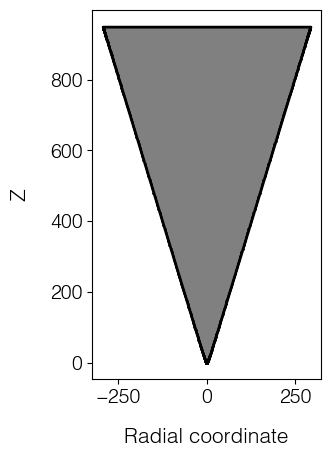

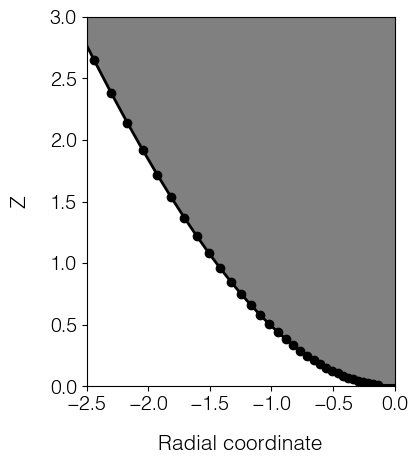

In [3]:
#-- Plot probe shape
P.plot_geometry(ms=1)


P.plot_geometry()
plt.gca().set_aspect('equal')
plt.xlim(-2.5,0)
plt.ylim(0,3)

<RotationalMoM.ImpedanceMatrix>:
	Preparing quasistatic mirror impedance matrix...
	Progress: 99.59%	Total quadrature time: 4.49s, time per quadrature evaluation: 7.66E-05s
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix...
	Progress: 99.59%	Total quadrature time: 12.40s, time per quadrature evaluation: 2.12E-04s


"\nr0=P.get_eigenrhos()[:10]\nr=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]\nr=AWA(sorted(r,key=lambda r: np.abs(r)))\ndr=(r-r0)\ndr.real.plot(alpha=.3,color='r',lw=10)\ndr.imag.plot(alpha=.3,color='b',lw=10)\nprint(np.abs(dr).max())"

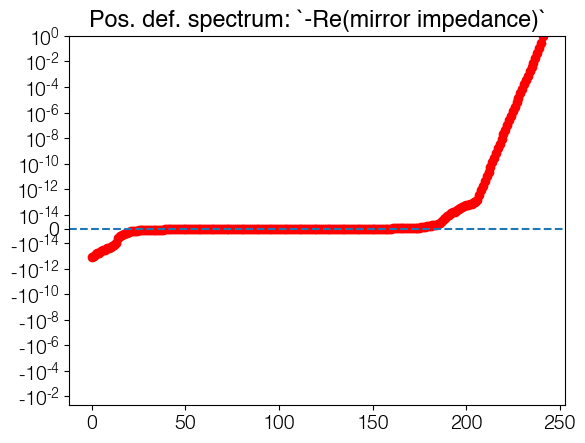

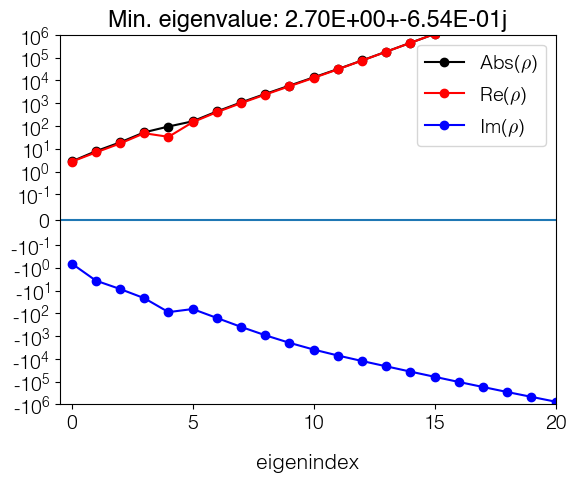

In [4]:
gap=1
P.set_gap(gap)
#P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
#                       Nkappas=244*4,kappa_max=10/gap,kappa_min=None,qquadrature=numrec.GL)
P.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
P.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P.plot_eigenrhos()

"""
r0=P.get_eigenrhos()[:10]
r=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]
r=AWA(sorted(r,key=lambda r: np.abs(r)))
dr=(r-r0)
dr.real.plot(alpha=.3,color='r',lw=10)
dr.imag.plot(alpha=.3,color='b',lw=10)
print(np.abs(dr).max())"""

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...


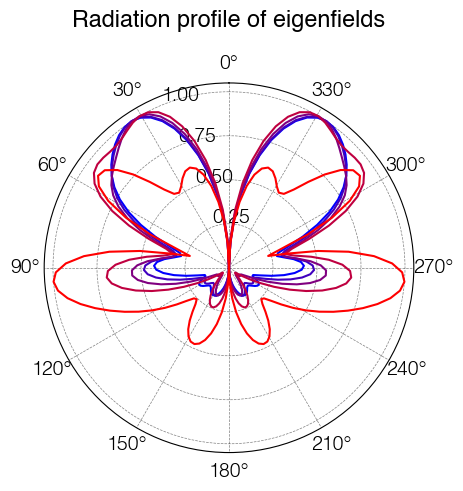

In [5]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),recompute=True)

N=5
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

## Probe spectroscopy

In [6]:
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc

#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

freqs = np.linspace(.1,60,300)*freq_THz

@misc.autopickle('ProbeFrequencySpectroscopy_taper=%i.pickle'%taper_angle)
def getFreqSpectroscopy(P, freqs=freqs, gap=1, Nmodes=20):
    
    P.set_gap(gap)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    FS = PS.ProbeFrequencySpectroscopyParallel(P,freqs,Nmodes=Nmodes)
    
    #This classification will be time-consuming, but robust
    FS.classify_eigensets(reversed=True,by_eigenrho=False)
    
    return FS

@misc.autopickle('ProbeEncoding_taper=%i.pickle'%taper_angle)
def getProbeEncoding(gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10):

    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max)
    
    return enc

<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=30, there were 300 identifiable mutual coordinates.


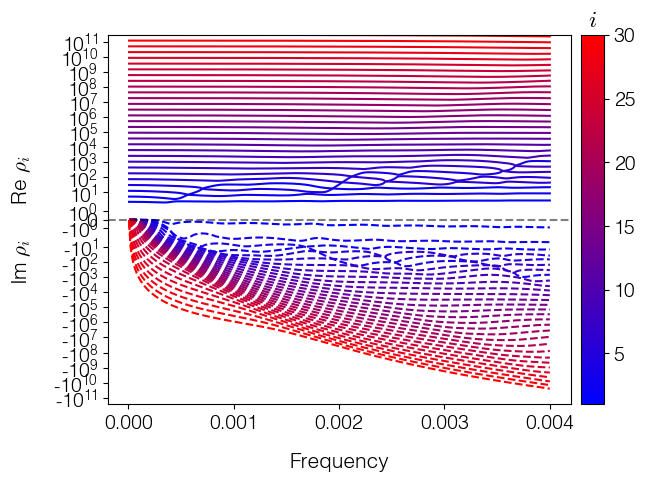

In [7]:
FreqSpectroscopy = getFreqSpectroscopy(P,recompute=False,overwrite=True,reload=True)
#FreqSpectroscopy(Nmodes=30,by_eigenrho=False)
FreqSpectroscopy.plot_eigenrhos(Nmodes=30)
plt.gcf().axes[0].set_xlabel('Frequency')
plt.gcf().axes[0].set_xscale('linear')

# Radiation patterns versus Frequency

In [8]:
Nmodes=10
freqs_set = FreqSpectroscopy.get_eigenrhos_AWA(Nmodes=Nmodes).axes[1]
Qs = FreqSpectroscopy.get_eigencharges_AWA(Nmodes=Nmodes)

illum_angles=np.linspace(0,180,50)
Bs=[]
for freq in freqs_set:
    print('Freq=%1.2e'%freq)
    P = FreqSpectroscopy.get_probe_at_coord(freq)
    P._eigencharges=Qs.cslice[:,freq]
    B = P.get_eigenbrightness(illum_angles=illum_angles,recompute=True)[:,:Nmodes]
    Bs.append(B)

Bs=AWA(Bs,axes=[freqs_set/freq_THz]+B.axes,
        axis_names = ['Frequency (THz)']+B.axis_names)

<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 300 identifiable mutual coordinates.
Freq=6.67e-06
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 6.67E-06...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.00e-05
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.00E-05...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.34e-05
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.34E-05...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=4.67e-05
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	U

Freq=4.34e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 4.34E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=4.47e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 4.47E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=4.61e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 4.61E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=4.74e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 4.74E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=8.61e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 8.61E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=8.75e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 8.75E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=8.88e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 8.88E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=9.01e-04
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 9.01E-04...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=1.29e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.29E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.30e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.30E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.32e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.32E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.33e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.33E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=1.72e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.72E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.73e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.73E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.74e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.74E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=1.76e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.76E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=2.14e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.14E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.16e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.16E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.17e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.17E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.18e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.18E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=2.57e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.57E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.58e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.58E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.60e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.60E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=2.61e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.61E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=3.00e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.00E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.01e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.01E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.03e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.03E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.04e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.04E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=3.43e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.43E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.44e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.44E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.45e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.45E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.47e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.47E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Freq=3.85e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.85E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.87e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.87E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.88e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.88E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness...
Freq=3.89e-03
<ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 3.89E-03...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.get_eigenbrightness>:
	C

Text(0.5, 1.0, 'Eigenbrightness 1')

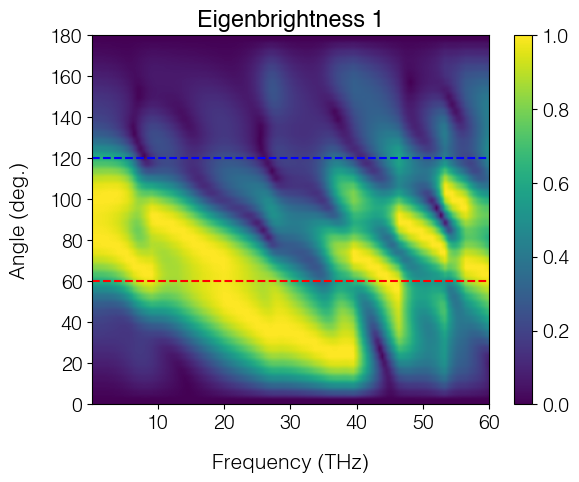

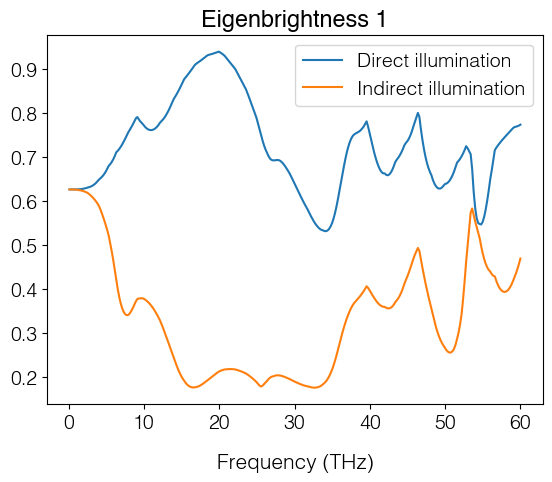

In [9]:
eigenindex=0
tmp = np.abs(Bs.cslice[:,:,eigenindex])
tmp = tmp/np.max(tmp,axis=1)[:,np.newaxis]
tmp.plot()
plt.axhline(60,ls='--',color='r')
plt.axhline(120,ls='--',color='b')
plt.title('Eigenbrightness %i'%(eigenindex+1))

plt.figure()
dangle=50
direct_range = slice(60-dangle/2,60+dangle/2)
indirect_range = slice(120-dangle/2,120+dangle/2)
np.mean(tmp.cslice[:,direct_range],axis=-1).plot(label='Direct illumination')
np.mean(tmp.cslice[:,indirect_range],axis=-1).plot(label='Indirect illumination')
plt.legend()
plt.title('Eigenbrightness %i'%(eigenindex+1))

Text(0.5, 1.0, 'Eigenbrightness 2')

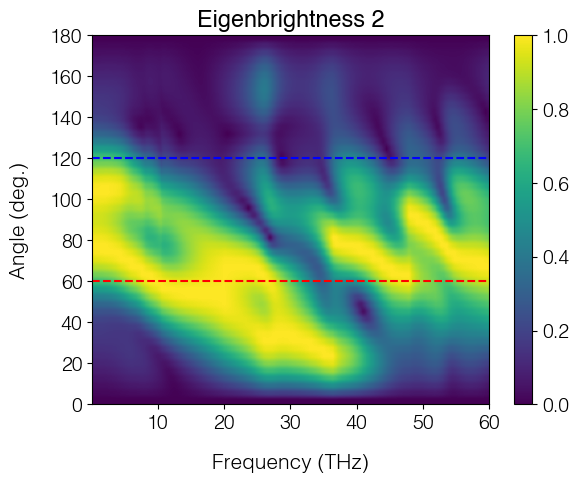

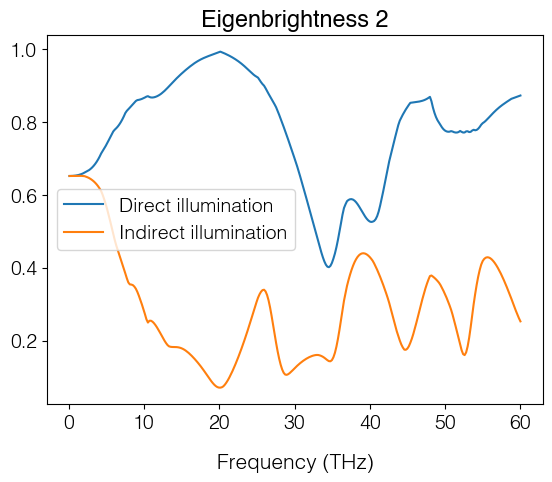

In [10]:
eigenindex=1
tmp = np.abs(Bs.cslice[:,:,eigenindex])
tmp = tmp/np.max(tmp,axis=1)[:,np.newaxis]
tmp.plot()
plt.axhline(60,ls='--',color='r')
plt.axhline(120,ls='--',color='b')
plt.title('Eigenbrightness %i'%(eigenindex+1))

plt.figure()
dangle=30
direct_range = slice(60-dangle/2,60+dangle/2)
indirect_range = slice(120-dangle/2,120+dangle/2)
np.mean(tmp.cslice[:,direct_range],axis=-1).plot(label='Direct illumination')
np.mean(tmp.cslice[:,indirect_range],axis=-1).plot(label='Indirect illumination')
plt.legend()
plt.title('Eigenbrightness %i'%(eigenindex+1))

Text(0.5, 1.0, 'Eigenbrightness 3')

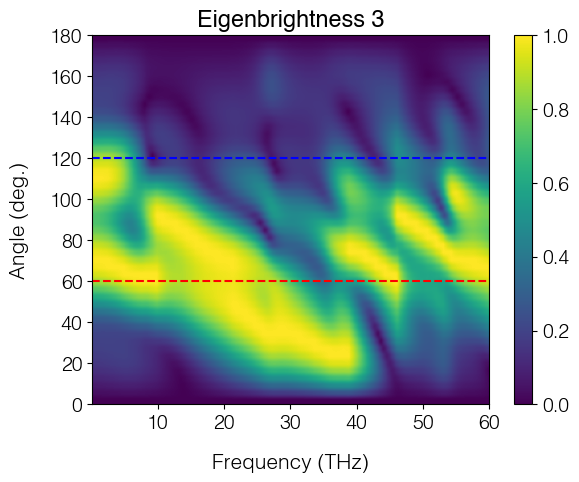

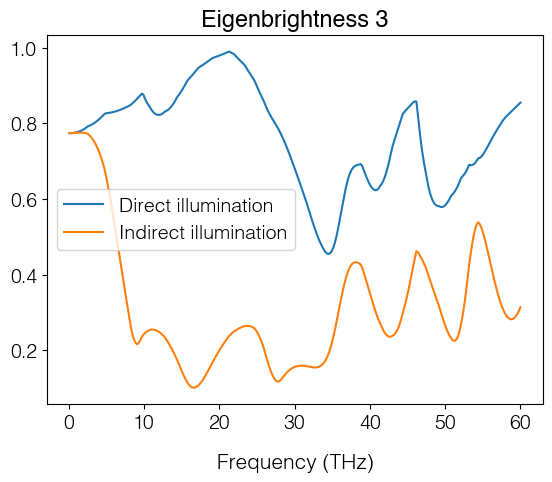

In [11]:
eigenindex=2
tmp = np.abs(Bs.cslice[:,:,eigenindex])
tmp = tmp/np.max(tmp,axis=1)[:,np.newaxis]
tmp.plot()
plt.axhline(60,ls='--',color='r')
plt.axhline(120,ls='--',color='b')
plt.title('Eigenbrightness %i'%(eigenindex+1))

plt.figure()
dangle=30
direct_range = slice(60-dangle/2,60+dangle/2)
indirect_range = slice(120-dangle/2,120+dangle/2)
np.mean(tmp.cslice[:,direct_range],axis=-1).plot(label='Direct illumination')
np.mean(tmp.cslice[:,indirect_range],axis=-1).plot(label='Indirect illumination')
plt.legend()
plt.title('Eigenbrightness %i'%(eigenindex+1))

Text(0.5, 1.0, 'Eigenbrightness 4')

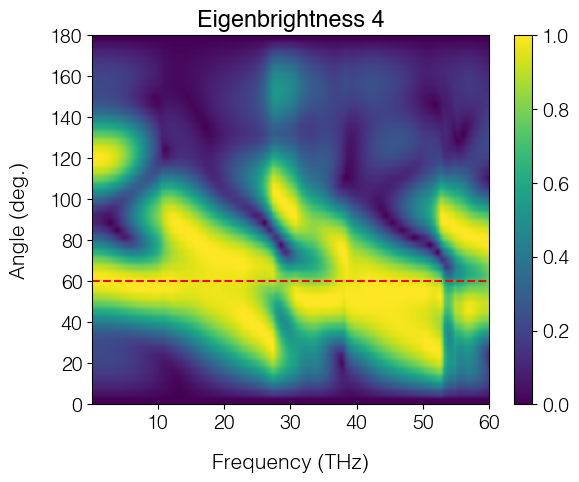

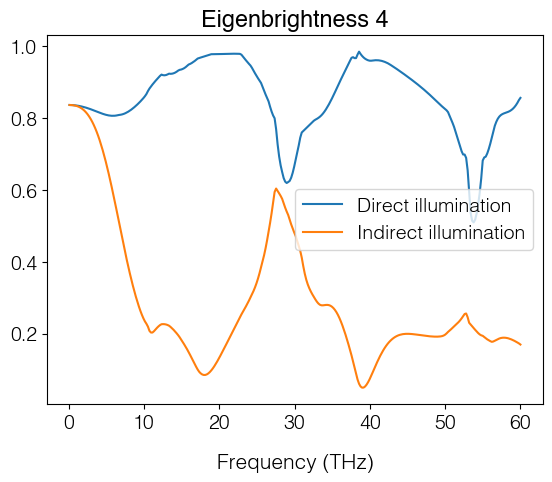

In [12]:
eigenindex=3
tmp = np.abs(Bs.cslice[:,:,eigenindex])
tmp = tmp/np.max(tmp,axis=1)[:,np.newaxis]
tmp.plot()
plt.axhline(60,ls='--',color='r')
plt.title('Eigenbrightness %i'%(eigenindex+1))

plt.figure()
dangle=30
direct_range = slice(60-dangle/2,60+dangle/2)
indirect_range = slice(120-dangle/2,120+dangle/2)
np.mean(tmp.cslice[:,direct_range],axis=-1).plot(label='Direct illumination')
np.mean(tmp.cslice[:,indirect_range],axis=-1).plot(label='Indirect illumination')
plt.legend()
plt.title('Eigenbrightness %i'%(eigenindex+1))

# Diagnostics on SiC

## Uniform settings

In [13]:
gapmin=.15
amplitude_nm=50
a_nm=20
amplitude = amplitude_nm / a_nm

freqs_wn = np.linspace(800,1000,50)
freqs = freqs_wn * (a_nm*1e-7)

freqs2_wn = np.linspace(800,1000,20) #less expensive
freqs2 = freqs2_wn * (a_nm*1e-7)

## Encoded calculation - near-field + quasi-static only

In [14]:
from NearFieldOptics import Materials as M
snorm_enc = Encoding.getNormalizedSignal(freqs_wn,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=24*4,gapmin=gapmin,
                                        rp_norm = M.Au.reflection_p,
                                        freqs_wn_norm = None)

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...


/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:535: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  freq,eps1,eps2=misc.extract_array(file, dtype=numpy.float).T


<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Stewart_V2O3film_insulating.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Stewart_V2O3film_metallic.csv"...


NameError: name 'Encoding' is not defined

In [ ]:
np.abs(snorm_enc['Sn'][3]).plot()

## Direct calculation - near-field + quasi-static only

In [ ]:
farfield=False
kwargs=dict(update_brightness=False,zquadrature=numrec.GL,Nzs = 24,
            Nkappas=244*2,kappa_max=10,kappa_min=0,
            Nmodes=15,farfield=farfield)
signals_ref=P.EradSpectrumDemodulated(freqs=freqs,rp=M.Au.reflection_p,
                                            zmin=gapmin, amplitude=amplitude,
                                            demod_order=5, **kwargs)
signals=P.EradSpectrumDemodulated(freqs=freqs, rp=rp,
                                        zmin=gapmin, amplitude=amplitude,
                                        demod_order=5, **kwargs)
snorm_QS = signals
snorm_QS['Sn'] /= signals_ref['Sn']
snorm_QS['Sn'].set_axes([None,freqs_wn])
snorm_QS['Erad'].set_axes([None,freqs_wn])

In [ ]:
n = 3
plt.plot(freqs_wn,
         np.abs(snorm_enc['Sn'][n]),label='Encoded result')
plt.plot(freqs_wn,
         np.abs(snorm_QS['Sn'][n]),label='Direct QS result')
#plt.ylim(0,15)
plt.xlim(800,1000)
plt.legend()

plt.figure()
plt.plot(freqs_wn,
        np.unwrap(np.angle(snorm_enc['Sn'][n])))
plt.plot(freqs_wn,
        np.unwrap(np.angle(snorm_QS['Sn'][n])))

plt.figure()
np.abs(snorm_enc['Erad']).plot(plotter=plt.contourf)
plt.title('Encoded result')
plt.figure()
np.abs(snorm_QS['Erad']).plot(plotter=plt.contourf)
plt.title('Direct QS result')